# CASE 5: All text feature as seperate field + Column normalization of originally numerical feature only



In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random 
import math as m

import warnings
warnings.filterwarnings('ignore')

from sklearn.naive_bayes                  import MultinomialNB
from sklearn.model_selection              import StratifiedKFold
from sklearn.preprocessing                import MinMaxScaler
from sklearn.model_selection              import train_test_split
from sklearn.feature_extraction.text      import CountVectorizer
from sklearn.feature_extraction.text      import TfidfVectorizer
from sklearn.impute                       import SimpleImputer
from sklearn.metrics                      import confusion_matrix
from sklearn                              import metrics
from sklearn.metrics                      import roc_curve, auc, roc_auc_score


from scipy.sparse                         import hstack


Function for vectorization 
> parameter
> 1. X_train       : training feature dataset
> 2. x_cv          : cross-validation feature dataset
> 3. Transform_type: Text feature extrctiion type--1 for bag of words & 2 for tf-idf

> Attribute
> 1. transformed feature of training data
> 2. Transformed feature of cross-validation data
> 3. Feature list

In [11]:
def Vectorization(x_train,x_cv,transform_type):
    ''' Txxt feature extraction of donor choose dataset '''
    vectorizer = None
    train_x = {}
    cv_x    = {}
#  Deciding Vectorizor
    if transform_type == 1:
        vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
    elif transform_type == 2:
        vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
        
# filling empty values
    for i in ['project_title','essay','project_resource_summary','project_grade_category',\
              'project_subject_subcategories','school_state','teacher_prefix','project_subject_categories']:
        x_train[i]  = x_train[i].fillna('')
        x_cv[i]     = x_cv[i].fillna('')
# Feature Transformation  
    features_list = list()
    for i in ['project_title','essay','project_resource_summary','project_grade_category',\
              'project_subject_subcategories','school_state','teacher_prefix','project_subject_categories']:
        vectorizer.fit(x_train[i].values)
        train_x[i]  = vectorizer.transform(x_train[i].values)
        cv_x[i]     = vectorizer.transform(x_cv[i].values)
        features    = vectorizer.get_feature_names()
        features_list.extend(features)      

    
# imputing missing value of price and quantity
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    imputer.fit(x_train['price'].values.reshape(-1,1))  
    train_x['price'] = imputer.transform(x_train['price'].values.reshape(-1, 1))
    cv_x['price'] = imputer.transform(x_cv['price'].values.reshape(-1, 1))
    
    imputer.fit(x_train['quantity'].values.reshape(-1,1))  
    train_x['quantity'] = imputer.transform(x_train['quantity'].values.reshape(-1, 1))
    cv_x['quantity'] = imputer.transform(x_cv['quantity'].values.reshape(-1, 1))
    
    train_x['teacher_number_of_previously_posted_projects']= x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)  
    cv_x['teacher_number_of_previously_posted_projects']= x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)    

# Column Normalizing all feature
    scaler = MinMaxScaler()
        
    for i in ['price','quantity','teacher_number_of_previously_posted_projects'] :
        scaler.fit(train_x[i])
        train_x[i]=scaler.transform(train_x[i])
        cv_x[i]=scaler.transform(cv_x[i])

#  merging all transformed feature set to ccreate new dataset
    x_train_ = hstack((train_x['project_title'] ,train_x['essay'],train_x['project_resource_summary'],\
                       train_x['project_grade_category'],train_x['project_subject_subcategories'],\
                       train_x['school_state'],train_x['teacher_prefix'],\
                       train_x['project_subject_categories'],train_x['price'],train_x['quantity'],\
                       train_x['teacher_number_of_previously_posted_projects'])).tocsr()       
    
    
    x_cv_    = hstack((cv_x['project_title'] ,cv_x['essay'] ,cv_x['project_resource_summary'],\
                       cv_x['project_grade_category'] ,cv_x['project_subject_subcategories'],\
                       cv_x['school_state'] ,cv_x['teacher_prefix'],\
                       cv_x['project_subject_categories'] ,cv_x['price'] ,cv_x['quantity'],\
                       cv_x['teacher_number_of_previously_posted_projects'])).tocsr()
    
    
    features_list.extend(['price','quantity','teacher_number_of_previously_posted_projects'])
# returning dataset    
    return x_train_ , x_cv_ ,features_list

Function GridSearchCV
> Parameters
> 1. x_train       : training features dataset
> 2. Y_train       : o/p Class label for dataset
> 3. classifier    : Model
> 4. folds         : no of folds for cross-validation
> 5. transform_type: decides test feature extraction type---1 for Bag of words & 2 for tf-idf vector 

>Attribute
> 1. roc_auc_score of train data
> 2. roc_auc_score of cross-validation data


In [12]:
def GridSearchCV(x_train,y_train,classifier,folds,transform_type) :
    """ K-fold cross validaion"""
    
# defining variables for storing auc score of training and cross-validataion data
    train_roc_auc_scores = []
    cv_roc_auc_scores    = []

    
# defining hyper-parameter list
    params = [10**4,10**3,10**2,10**1,10**0,10**-1,10**-2,10**-3,10**-4]

# iteration over each value of hyper-parameter
    for hyper_param in tqdm(params):

# defining temperory varaibles for storing auc_score of training and cros_validation data for each fold
        train_roc_auc_score_for_avg     = []
        cv_roc_auc_score_for_avg        = []
        

#  creating indices for each fold and iteration over each fold
        folds_indices    = StratifiedKFold(n_splits=folds,shuffle=True)
        for train_ind, cv_ind in folds_indices.split(x_train, y_train):
            temp_train_x = x_train.iloc[train_ind]
            train_y      = y_train.iloc[train_ind]
            temp_cv_x    = x_train.iloc[cv_ind]
            cv_y         = y_train.iloc[cv_ind]
            
            
# Vectorization the dataset and creating final training and cvv dataset to operate
            train_x, cv_x,feature = Vectorization(temp_train_x,temp_cv_x,transform_type)
    
            
# Assigning hyper-arameter to model or classifier and fitting it on training data
            classifier.alpha = hyper_param
            classifier.fit(train_x,train_y)
            
# Predicting log_probanilities for training and cv data and calulating roc_auc_score and storing it in temperory variables
            predictions   = classifier.predict_log_proba(train_x)[:,1]
            train_roc_auc_score_for_avg.append( roc_auc_score(train_y,predictions) )       
 
            
            predictions   = classifier.predict_log_proba(cv_x)[:,1]            
            cv_roc_auc_score_for_avg.append( roc_auc_score(cv_y,predictions) )        

            

    
# Averaging the roc_auc_score values of all folds and storing it it final variable 
        train_roc_auc_scores.append(np.mean(train_roc_auc_score_for_avg))
        cv_roc_auc_scores.append(np.mean(cv_roc_auc_score_for_avg)) 


# Returing the values 
    return train_roc_auc_scores,cv_roc_auc_scores

Function for plotting graph of roc_auc_score Vs hyer-parameter
> Parameter 
> 1. train   : list of values of roc_auc_score of training data
> 2. cv      : list of values of roc_auc_score of cross-vlidation data
> 3. param   : list of hyper-parameter

In [13]:
def Curve_plot(train,cv,param):
    plt.grid()
    plt.plot( param,train, label='Train AUC')
    plt.plot(param, cv, label='CV AUC')
    plt.scatter( param,train,label='Train AUC points')
    plt.scatter(param, cv, label='CV AUC points')
    plt.xscale('log')
    plt.xlabel("Hyperparameters")
    plt.ylabel("ROC_AUC_Score")
    plt.legend()
    plt.title("ROC_AUC_Score VS Hypermeter")
    plt.show()

In [14]:
def top_n_feature(n,fe,prpo):
    ''' finds top n features fe: list of feature & prpo :feature_log_probability'''
    arr = np.array(fe)
    return  arr[list(np.argsort(prpo)[::-1][:n])]
    

In [15]:
data = pd.read_csv('donor_choose.csv')

In [16]:
# seperating class label from feature
label    = data['project_is_approved']
feature  = data.drop(['project_is_approved'],axis=1)

# Spiliting Data into train and test
x_train, x_test, y_train, y_test = train_test_split(feature,label,test_size=.33,stratify=label)


In [17]:
param=[10**4,10**3,10**2,10**1,10**0,10**-1,10**-2,10**-3,10**-4]

>For BOW repreentation

In [18]:
# Hyperparameter Tuning
#  GridSearchCV(x_train,y_train,classifier,folds,transform_type)
t_sc_1,cv_sc_1= GridSearchCV(x_train,y_train,MultinomialNB(),3,1)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [1:37:05<00:00, 679.09s/it]

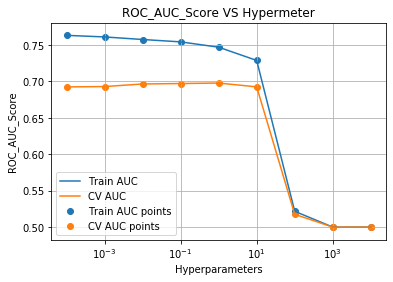

In [19]:
# Curve_plot(train score,cv score,param)
Curve_plot(t_sc_1,cv_sc_1,param)

> Best Hyper-parameter for BOW--->1

In [20]:
# Vectorizing trainin and testing data
X_train_1,X_test_1,feature_list=Vectorization(x_train,x_test,1)

In [53]:
#  Defining Model
model=MultinomialNB(alpha=1)

In [54]:
# Fitting Model
model.fit(X_train_1,y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [55]:
# Predcing log probability & calculating Auc score on training set
_1_tr_pred     = model.predict_log_proba(X_train_1)[:,1]
_1_tr_score    = roc_auc_score(y_train,_1_tr_pred)

In [56]:
# Predcing log probability & calculating Auc score on test set
_1_te_pred        = model.predict_log_proba(X_test_1)[:,1]
_1_te_score       = roc_auc_score(y_test,_1_te_pred )

In [57]:
# Collecting TPR,FPR & thresholds for Train & Test set
_1_tr_fpr ,_1_tr_tpr ,_1_tr_thresold = roc_curve(y_train,_1_tr_pred )
_1_te_fpr ,_1_te_tpr ,_1_te_thresold = roc_curve(y_test,_1_te_pred )

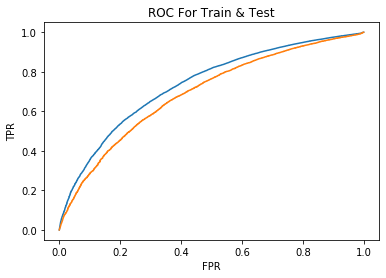

AUC Score for Train == 0.7355725763580385
AUC Score for Test  == 0.691990321800742


In [58]:
# ploting ROC Curve
plt.plot(_1_tr_fpr ,_1_tr_tpr,label='Train ROC')
plt.plot(_1_te_fpr ,_1_te_tpr,label='Test ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC For Train & Test')
plt.show()

# printing AUC values
print('AUC Score for Train ==',_1_tr_score )
print('AUC Score for Test  ==',_1_te_score )

In [59]:
# calculating confusion matrix
tn_1,fp_1,fn_1,tp_1=confusion_matrix (y_test,[ 0 if _1_te_pred[i] < m.log(0.5) else 1 for i in range(len(_1_te_pred))]).ravel()

In [60]:
# Printing Confusion Matrix 
print(f'''Confusion Matrix
     
               Predicted
             
         ___|__0___|__1____|
   A        |      |       |
   c     0  | {tn_1} |  {fp_1} |
   t     ___|______|_______|
   u        |      |       |
   a     1  | {fn_1} |  {tp_1}|
   l     ___|______|_______|''',)

Confusion Matrix
     
               Predicted
             
         ___|__0___|__1____|
   A        |      |       |
   c     0  | 3035 |  2424 |
   t     ___|______|_______|
   u        |      |       |
   a     1  | 8608 |  21984|
   l     ___|______|_______|


In [61]:
print('Top 20 useful feature for predicting class 1 are following :\n \n' , top_n_feature(20,feature_list,model.feature_log_prob_[1]))

Top 20 useful feature for predicting class 1 are following :
 
 ['student' 'learn' 'school' 'classroom' 'use' 'help' 'not' 'need' 'work'
 'student' 'need' 'student need' 'read' 'many' 'come' 'book' 'love'
 'class' 'make' 'day']


> For Tf-idf repreentation

In [30]:
#  GridSearchCV(x_train,y_train,classifier,folds,transform_type)
t_sc_2,cv_sc_2 = GridSearchCV(x_train,y_train,MultinomialNB(),3,2)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [1:35:13<00:00, 603.42s/it]

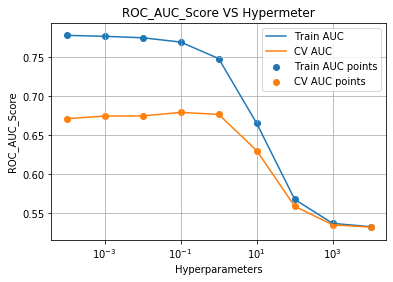

In [31]:
Curve_plot(t_sc_2,cv_sc_2,param)

>Best Hyper-parameter for Ti-idf ----->0.1

In [32]:
# Vectorizing trainin and testing data
X_train_2,X_test_2,feature_list_2=Vectorization(x_train,x_test,2)

In [43]:
#  Defining Model
model_2=MultinomialNB(alpha=0.1)

In [44]:
# Fitting Model
model_2.fit(X_train_2,y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [45]:
# Predcing log probability & calculating Auc score on training set
_2_tr_pred     = model_2.predict_log_proba(X_train_2)[:,1]
_2_tr_score    = roc_auc_score(y_train,_2_tr_pred)

In [46]:
# Predcing log probability & calculating Auc score on test set
_2_te_pred        = model_2.predict_log_proba(X_test_2)[:,1]
_2_te_score       = roc_auc_score(y_test,_2_te_pred )

In [47]:
# Collecting TPR,FPR & thresholds for Train & Test set
_2_tr_fpr ,_2_tr_tpr ,_2_tr_thresold = roc_curve(y_train,_2_tr_pred )
_2_te_fpr ,_2_te_tpr ,_2_te_thresold = roc_curve(y_test,_2_te_pred )

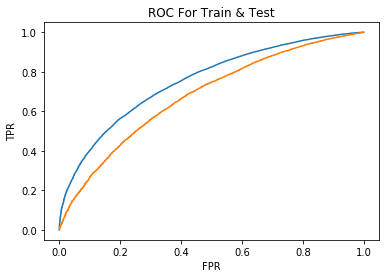

AUC Score for Train == 0.7542776772270601
AUC Score for Test  == 0.6791352123015159


In [48]:
plt.plot(_2_tr_fpr ,_2_tr_tpr,label='Train ROC')
plt.plot(_2_te_fpr ,_2_te_tpr,label='Test ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC For Train & Test')
plt.show()

# printing AUC values
print('AUC Score for Train ==',_2_tr_score )
print('AUC Score for Test  ==',_2_te_score )

In [49]:
# calculating confusion matrix
tn_2,fp_2,fn_2,tp_2=confusion_matrix (y_test,[ 0 if _2_te_pred[i] < m.log(0.5) else 1 for i in range(len(_2_te_pred))]).ravel()

In [50]:
# Printing Confusion Matrix 
print(f'''Confusion Matrix
     
               Predicted
             
         ___|__0___|__1____|
   A        |      |       |
   c     0  | {tn_2} |  {fp_2} |
   t     ___|______|_______|
   u        |      |       |
   a     1  | {fn_2} |  {tp_2}|
   l     ___|______|_______|''',)

Confusion Matrix
     
               Predicted
             
         ___|__0___|__1____|
   A        |      |       |
   c     0  | 1590 |  3869 |
   t     ___|______|_______|
   u        |      |       |
   a     1  | 3510 |  27082|
   l     ___|______|_______|


In [51]:
print('Top 20 useful feature for predicting class 1 are following :\n \n' , top_n_feature(20,feature_list_2,model_2.feature_log_prob_[1]))

Top 20 useful feature for predicting class 1 are following :
 
 ['mrs' 'grades_prek_2' 'ms' 'grades_3_5' 'literacy language' 'literacy'
 'language' 'literacy' 'grades_6_8' 'ca' 'math' 'science' 'math science'
 'student' 'mathematics' 'grades_9_12' 'mr' 'literature writing'
 'literature' 'writing']


 
<table>
    <caption>Summary</caption>
    <tr><th>Vectorizer</th><th>Model</th><th>Hyper-parameter</th><th>AUC</th> </tr>
    <tr><td>BOW</td><td>MultinomialNB</td><td>0.01</td><td>0.691990321800742</td></tr>
    <tr><td>TFIDf</td><td>MultinomialNB</td><td>0.01</td><td>0.6791352123015159</td></tr>

</table>

*******************************************************************************************************************************